# Chapter 6 Linear model selection and regularisation : Lab

In this lab we implement many of the techniques discussed in this chapter. We import some of our libraries at this top level.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import itertools
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.model_selection import KFold
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

In [32]:
# Import the csv file
df_hitters = pd.read_csv('..\Data sets\Hitters.csv')
df_hitters_raw = df_hitters

# Here is a nice way to check if there are any na values in the dataframe
print(df_hitters.isna().sum().sum())
print(df_hitters.isna().sum())

59
AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64


In [33]:
# Drop the nan values
df_hitters = df_hitters.dropna()
df_hitters.isna().sum().sum()

0

In [34]:
df_hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [35]:
# Create dummy variables for some columns
qual = ['League', 'Division', 'NewLeague']

df_hitters = pd.get_dummies(df_hitters, columns=qual)
df_hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,...,325,9,3,700.0,0,1,1,0,0,1
318,492,136,5,76,50,94,12,5511,1511,39,...,313,381,20,875.0,1,0,1,0,1,0
319,475,126,3,61,43,52,6,1700,433,7,...,37,113,7,385.0,1,0,0,1,1,0
320,573,144,9,85,60,78,8,3198,857,97,...,1314,131,12,960.0,1,0,1,0,1,0


### Subset selection methods

We first choose the best model using forward selection based on Cp (6.2). This score is not built in as a metric to sklearn. We therefore define a
function to compute it ourselves, and use it as a scorer. By default, sklearn tries to maximize a score, hence our scoring function computes the negative Cp statistic.

In [43]:
def get_models(k, X, y):
    """Fit all posible models that contain exactly ki predictors"""

    # List all possible predictors
    X_combos = itertools.combinations(list(X.columns), k)

    # Fit all models with the possible combinations
    models = []
    for X_label in X_combos:
        X_smf = ' + '.join(X_label)
        f = 'Salary ~ {}'.format(X_smf)

        # Fit the model
        model = smf.ols(formula=f, data=pd.concat([X,y], axis=1)).fit()

        # Return results
        models += [(f, model)]
    return models

def min_rss(statsmodels):
    """Return model with lowest residual sum of squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]

def max_adjr2(statsmodels):
    """Return model with highest adjusted R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]

#### Which model with 2 predictors yields the lowest RSS score?

In [45]:
# Define X and y matrix
X = df_hitters.drop(columns='Salary')
y = df_hitters['Salary']

# Set number of predictors
k = 2

# Get all possible predictors
subset = get_models(k, X, y)

# Display results
print('This model yields the lowest RSS score for the subset of models with {} predictors:'.format(k))
display(min_rss(subset))

print('This model yields the highest adjusted R-squared score for the subset of models with {} predictors:'.format(k))
display(max_adjr2(get_models(k, X, y)))

This model yields the lowest RSS score for the subset of models with 2 predictors:


('Salary ~ Hits + CRBI',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x20162517fd0>)

This model yields the highest adjusted R-squared score for the subset of models with 2 predictors:


('Salary ~ Hits + CRBI',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x20165145290>)

#### How do the maximum $R^2$, minimum RSS, and BIC statistics vary for each subset with k predictors?

How many models will we need to fit for our example? We will need to fit about 700 000 models.

Text(0, 0.5, 'Combinations')

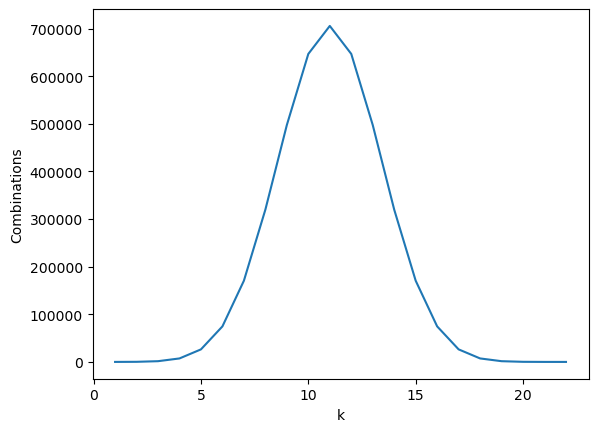

In [56]:
from scipy.special import factorial

p = df_hitters.drop(columns='Salary').shape[1]
k = np.arange(1, n+1)
y = factorial(n) / (factorial(k)*factorial(n-k))

ax = sns.lineplot(x=k, y=y)
plt.xlabel('k')
plt.ylabel('Combinations')

In [57]:
# Pick arbitrary subset of predictors to save compute/memory
X = df_hitters.loc[:, 'AtBat':'PutOuts']
y = df_hitters['Salary']

# get all model results
model_subsets = []
for k in range(len(X.columns)):
    k=k+1
    subset = get_models(k, X, y)
    model_subsets += [subset]
    print('Progess: k = {}, done'.format(k))

Progess: k = 1, done
Progess: k = 2, done
Progess: k = 3, done
Progess: k = 4, done
Progess: k = 5, done
Progess: k = 6, done
Progess: k = 7, done
Progess: k = 8, done
Progess: k = 9, done
Progess: k = 10, done
Progess: k = 11, done
Progess: k = 12, done
Progess: k = 13, done
Progess: k = 14, done


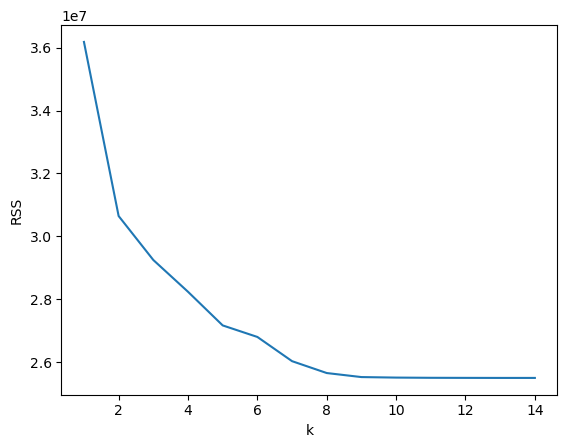

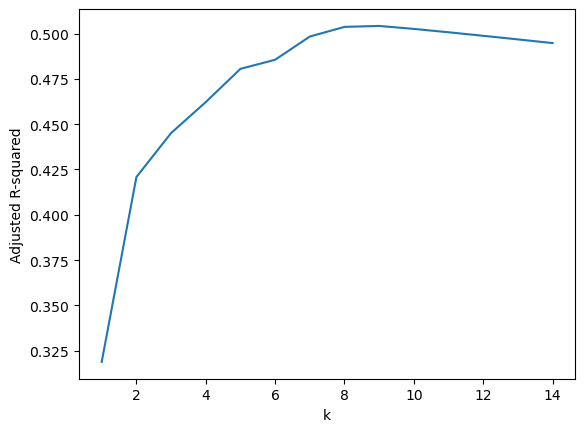

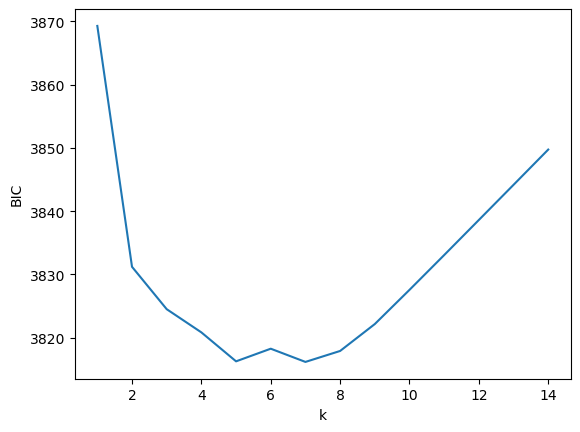

In [59]:
# Get the best rss score for each subset
rss = [min_rss(m)[1].ssr for m in model_subsets]

# Get best R-squared score for each subset
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in model_subsets]
k = np.arange(1, len(rss)+1)

# Get best BIC
def min_BIC(statsmodels):
    """Return the model with the lowest BIC"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

bic = [min_BIC(m)[1].bic for m in model_subsets]

ax = sns.lineplot(x=k, y=rss)
plt.xlabel('k')
plt.ylabel('RSS')
plt.show()

sns.lineplot(x=k, y=adjr2)
plt.xlabel('k')
plt.ylabel('Adjusted R-squared')
plt.show()

ax = sns.lineplot(x=k, y=bic)
plt.xlabel('k')
plt.ylabel('BIC')
plt.show()

In [61]:
best_subset_6 = list(min_rss(model_subsets[5])[1].params.index)[1:]
print(best_subset_6)

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']


In [62]:
list(max_adjr2(model_subsets[5])[1].params.index)[1:]

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']

In [63]:
list(max_adjr2(model_subsets[5])[1].params.index)[1:]

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']

All methods yield the same 6 best predictors.

### Forward and backward stepwise selection